In [76]:
import numpy as np
import matplotlib.pyplot as plt
import xarray
import cartopy.crs as ccrs

In [4]:
grd = xarray.open_dataset('NISKINESAB_2km.nc')
grd

<xarray.Dataset>
Dimensions:     (two: 2, bath: 2, eta_rho: 142, xi_rho: 154, eta_psi: 141, xi_psi: 153, eta_u: 142, xi_u: 153, eta_v: 141, xi_v: 154)
Dimensions without coordinates: two, bath, eta_rho, xi_rho, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/47)
    xl          float64 ...
    el          float64 ...
    JPRJ        (two) |S1 ...
    PLAT        (two) float64 ...
    PLONG       float64 ...
    ROTA        float64 ...
    ...          ...
    mask_rho    (eta_rho, xi_rho) float64 ...
    mask_u      (eta_u, xi_u) float64 ...
    mask_v      (eta_v, xi_v) float64 ...
    mask_psi    (eta_psi, xi_psi) float64 ...
    angle       (eta_rho, xi_rho) float64 ...
    wtype_grid  (eta_rho, xi_rho) float64 ...
Attributes:
    type:         Gridpak file
    gridid:       NISKINESAB_2km
    history:      Gridpak, Version 5.3
    CPP-options:   DCOMPLEX, DBLEPREC, ELLIPSOID, NISKINE, DRAW_COASTS, PLOTS,

In [150]:
# I assume the projection is maybe Lambert Conformal Conic?
# I need to figure out the exact projection for it to work correctly
# Hopefully my guess is close enough.
# Ideally, we need to do this in spherical coordinates. You will get the idea.

# Get the two required projections
pc = ccrs.PlateCarree()
lcc = ccrs.LambertConformal(central_longitude=grd.PLONG.values, central_latitude=grd.PLAT.values)

# transform lat/lon points to LCC projected x/y
xr, yr = lcc.transform_points(pc, grd.lon_rho.values, grd.lat_rho.values)[:, :, :-1].transpose((2, 0, 1))

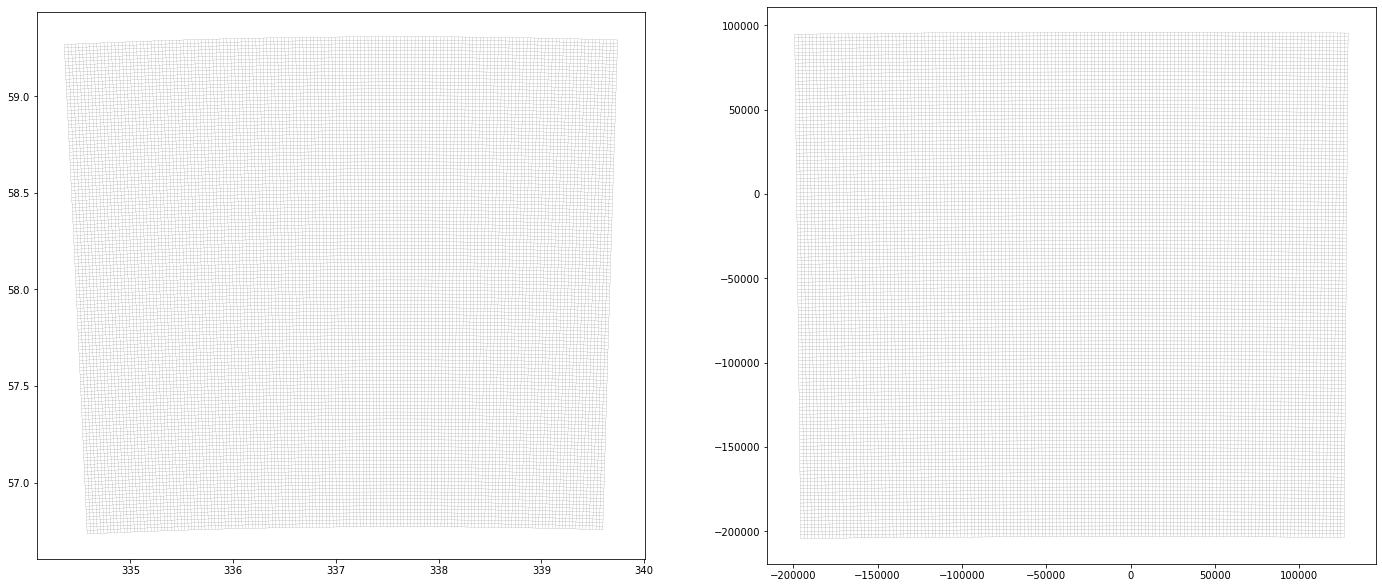

In [182]:
llaspect = 1.0/np.cos(np.pi*grd.PLAT.values.mean()/180.0)

fig, axs = plt.subplots(1, 2, figsize=(24, 12))
axs[0].plot(grd.lon_rho.values, grd.lat_rho.values, '-k', lw=0.1)
axs[0].plot(grd.lon_rho.values.T, grd.lat_rho.values.T, '-k', lw=0.1)
axs[0].set_aspect(llaspect)
# axs[0].set_xlim(grd.lon_rho.min().values, grd.lon_rho.max().values)
axs[1].plot(xr, yr, '-k', lw=0.1)
axs[1].plot(xr.T, yr.T, '-k', lw=0.1)
axs[1].set_aspect(1.0)

In [152]:
# This function is from https://github.com/pygridgen/pygridgen/blob/master/pygridgen/grid.py#L1014

def rho_to_vert(xr, yr, pm, pn, ang):  # pragma: no cover
    """ Possibly converts centroids to nodes """
    Mp, Lp = xr.shape
    x = np.empty((Mp + 1, Lp + 1), dtype='d')
    y = np.empty((Mp + 1, Lp + 1), dtype='d')
    x[1:-1, 1:-1] = 0.25 * (xr[1:, 1:] + xr[1:, :-1] + xr[:-1, 1:] + xr[:-1, :-1])
    y[1:-1, 1:-1] = 0.25 * (yr[1:, 1:] + yr[1:, :-1] + yr[:-1, 1:] + yr[:-1, :-1])

    # east side
    theta = 0.5 * (ang[:-1, -1] + ang[1:, -1])
    dx = 0.5 * (1.0 / pm[:-1, -1] + 1.0 / pm[1:, -1])
    dy = 0.5 * (1.0 / pn[:-1, -1] + 1.0 / pn[1:, -1])
    x[1:-1, -1] = x[1:-1, -2] + dx * np.cos(theta)
    y[1:-1, -1] = y[1:-1, -2] + dx * np.sin(theta)

    # west side
    theta = 0.5 * (ang[:-1, 0] + ang[1:, 0])
    dx = 0.5 * (1.0 / pm[:-1, 0] + 1.0 / pm[1:, 0])
    dy = 0.5 * (1.0 / pn[:-1, 0] + 1.0 / pn[1:, 0])
    x[1:-1, 0] = x[1:-1, 1] - dx * np.cos(theta)
    y[1:-1, 0] = y[1:-1, 1] - dx * np.sin(theta)

    # north side
    theta = 0.5 * (ang[-1, :-1] + ang[-1, 1:])
    dx = 0.5 * (1.0 / pm[-1, :-1] + 1.0 / pm[-1, 1:])
    dy = 0.5 * (1.0 / pn[-1, :-1] + 1.0 / pn[-1, 1:])
    x[-1, 1:-1] = x[-2, 1:-1] - dy * np.sin(theta)
    y[-1, 1:-1] = y[-2, 1:-1] + dy * np.cos(theta)

    # here we are now going to the south side..
    theta = 0.5 * (ang[0, :-1] + ang[0, 1:])
    dx = 0.5 * (1.0 / pm[0, :-1] + 1.0 / pm[0, 1:])
    dy = 0.5 * (1.0 / pn[0, :-1] + 1.0 / pn[0, 1:])
    x[0, 1:-1] = x[1, 1:-1] + dy * np.sin(theta)
    y[0, 1:-1] = y[1, 1:-1] - dy * np.cos(theta)

    # corners
    x[0, 0] = 4.0 * xr[0, 0] - x[1, 0] - x[0, 1] - x[1, 1]
    x[-1, 0] = 4.0 * xr[-1, 0] - x[-2, 0] - x[-1, 1] - x[-2, 1]
    x[0, -1] = 4.0 * xr[0, -1] - x[0, -2] - x[1, -1] - x[1, -2]
    x[-1, -1] = 4.0 * xr[-1, -1] - x[-2, -2] - x[-2, -1] - x[-1, -2]

    y[0, 0] = 4.0 * yr[0, 0] - y[1, 0] - y[0, 1] - y[1, 1]
    y[-1, 0] = 4.0 * yr[-1, 0] - y[-2, 0] - y[-1, 1] - y[-2, 1]
    y[0, -1] = 4.0 * yr[0, -1] - y[0, -2] - y[1, -1] - y[1, -2]
    y[-1, -1] = 4.0 * yr[-1, -1] - y[-2, -2] - y[-2, -1] - y[-1, -2]

    return x, y


In [153]:
xv, yv = rho_to_vert(xr, yr, grd.pm.values, grd.pn.values, grd.angle.values)

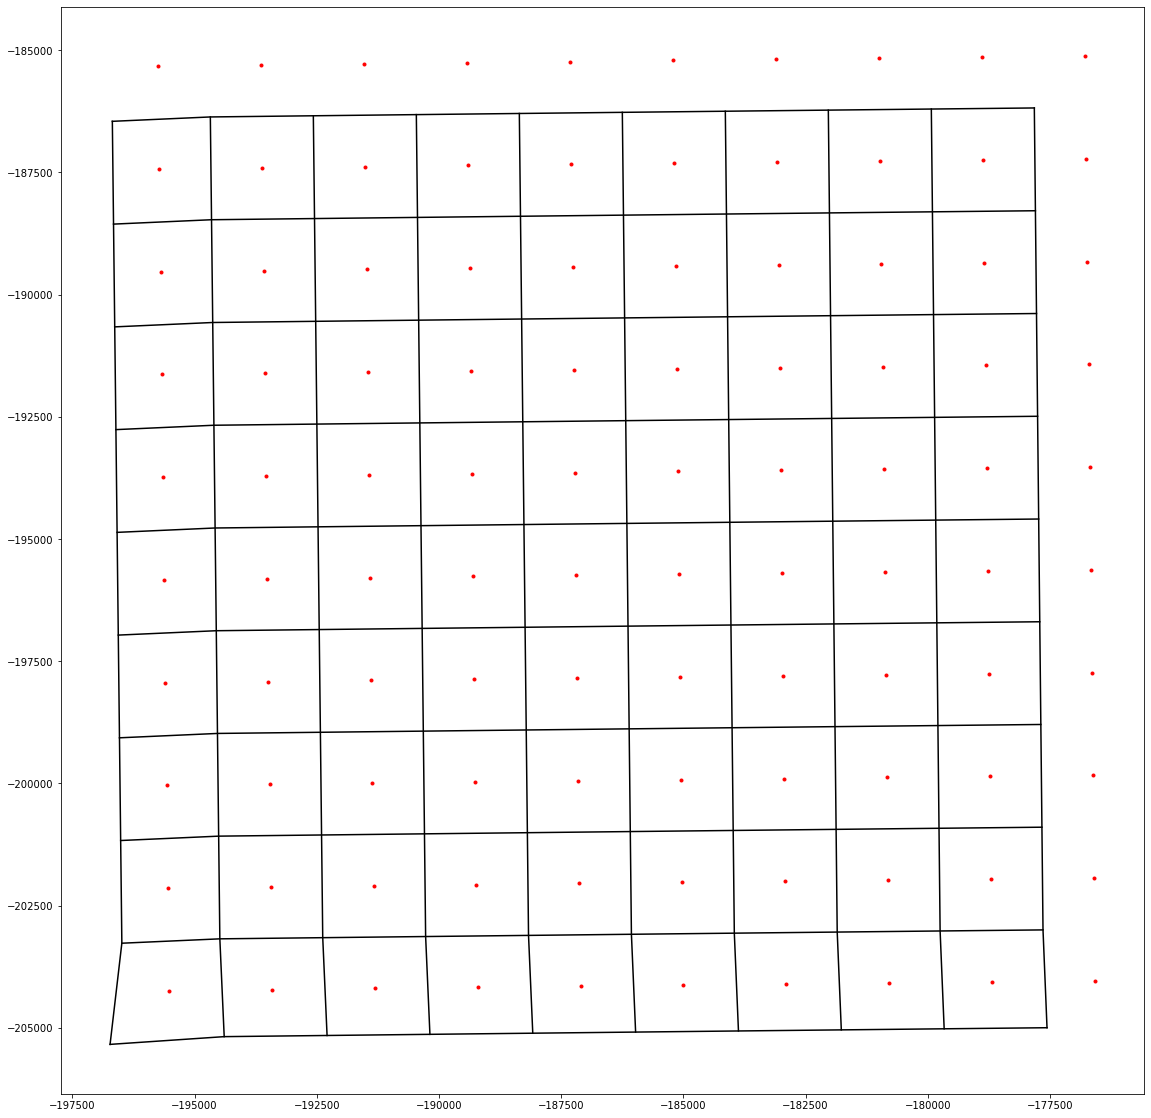

In [154]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.plot(xr[:10, :10], yr[:10, :10], 'r.')
ax.plot(xv[:10, :10], yv[:10, :10], 'k-')
ax.plot(xv[:10, :10].T, yv[:10, :10].T, 'k-');
ax.set_aspect(1.0)